# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Sun Feb  1 10:47:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 20.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [4]:
!pip install bert-extractive-summarizer

In [5]:
!pip install pytorch-ignite
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.8/343.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.6 MB/s eta 0:00:00


## importowanie datesetu

In [6]:
from datasets import load_dataset


ds = load_dataset("EdinburghNLP/xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 1500)
split_result = ds["test"].train_test_split(test_size=2, seed=42)
shots = split_result["test"]
ds["test"] = split_result["train"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Filter:   0%|          | 0/204045 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11332 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11334 [00:00<?, ? examples/s]

In [7]:
print(ds)
print(shots)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 84554
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4689
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [8]:
from summarizer import Summarizer
model_bertsum = Summarizer()

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
from ignite.metrics import Rouge

m = Rouge(variants=["L", 1], multiref="best")

candidate = "the cat is not there".split()
references = [
    "the cat is on the mat".split(),
    "there is a cat on the mat".split()
]

m.update(([candidate], [references]))

print(m.compute())

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [10]:
num_workers = 1
batch_size = 1

In [11]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(500))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 1
})


In [12]:
import random
random_index = random.randint(0, len(ds["test"]) - 1)
showcase_dataset = ds["test"].select([random_index])
showcase_loader = DataLoader(showcase_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
batch = next(iter(showcase_loader))
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")

Document: Hertfordshire Police said it was looking for Aidan Chaves in connection with "an incident of affray" in Sawbridgeworth, Hertfordshire.
The game between Sawbridgeworth Town and Clapton FC on 25 March was abandoned.
It followed reports a player appeared to get a  knife out after being spat at by a Clapton fan.
Mr Chaves is believed to be in Hertfordshire.
Police said the 26-year-old also had connections to London.
The Essex Senior League match, taking place at Sawbridgeworth's Crofters End ground, was abandoned after 95 minutes.
Following the match Sawbridgeworth Town said a player's registration had been terminated.
A spokesman for the club said the player in question would "never represent" them again and had been given a life ban from the ground.
Clapton was declared the winner because the score stood as it was at 95 minutes Sawbridgeworth Town 0 - Clapton 1.
Target: A non-league footballer who allegedly brandished a knife at an opposition fan is being sought by police.


In [52]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
    prints = False,
    chat = False
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        if chat:
          prompted = [
            {"role": "user", "content": f"{prompt} {doc}"} for doc in batch["document"]
          ]

          text = tokenizer.apply_chat_template(
              prompted,
              tokenize=False,
              add_generation_prompt=True
          )
          inputs = tokenizer([text], return_tensors="pt").to(model.device)
        else:
          inputs = tokenizer(
              prompted,
              return_tensors="pt",
              padding=True,
              truncation=True,
              max_length=4096,
          )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    if prints:
      # print(f"Doc: {batch['document'][0]}")
      print(f"Prediction: {predictions[0]}")
      # print(f"Target: {batch['summary'][0]}")

    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]
    m.update((predictions, targets))
    # print(m.compute())
    return m.compute()

In [50]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ], models = ['Qwen 1.5 0.5B - LoRa', 'Qwen 1.5 0.5B - few shot 1', 'Qwen 1.5 0.5B - few shot 3', 'Qwen 1.5 0.5B - zero shot','Qwen 1.5 0.5B - chat', 'Bertsum - bert-base-uncased', 'Bertsum - Sbertmodel', 'Bertsum - roberta-base','Qwen 2.5 3B - zero shot', 'Qwen 2.5 3B - few shot 1',  'Qwen 2.5 3B - few shot 3', 'Qwen 2.5 3B - instruct']):
    x = np.arange(len(labels))
    width = 0.075

    plt.figure(figsize=(45, 12))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=models[i])
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [15]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [16]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [17]:
import numpy as np
from tqdm.notebook import tqdm
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    prints = False,
    chat=False
) -> float:
    results = []
    loader_bar = tqdm(data_loader, desc="Calculating ROUGE average score", leave=False)
    for i, batch in enumerate(loader_bar):

        m = Rouge(variants=[1,2,"L"], multiref="best")

        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
            prints,
            chat,
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [18]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
    prints = False,
    chat = False
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
            prints=prints,
            chat=chat
        )

    return loss




In [19]:
from torch import nn
data_bertsum = evaluate_model(model_bertsum, test_loader, device='cuda', bert=True, tokenizer=None)



Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
from summarizer.sbert import SBertSummarizer
model_sbert = SBertSummarizer('paraphrase-MiniLM-L6-v2')
data_bertsum_sbert = evaluate_model(model_sbert, test_loader, device='cuda', bert=True, tokenizer=None)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
from summarizer import TransformerSummarizer
model_roberta = TransformerSummarizer(transformer_type="Roberta", transformer_model_key="roberta-base")
data_bertsum_roberta = evaluate_model(model_roberta, test_loader, device='cuda', bert=True, tokenizer=None)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots = ds["train"].train_test_split(train_size=size, seed=35)["train"]
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
    return prompt


In [23]:
!pip uninstall -y unsloth unsloth_zoo

# 2. Install Unsloth Zoo DIRECTLY from Git (to get 'tiled_mlp')
!pip install --upgrade --no-cache-dir "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git"

# 3. Install Unsloth main library from Git
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

  Cloning https://github.com/unslothai/unsloth-zoo.git to /tmp/pip-install-6m6xr152/unsloth-zoo_c5fdff3a4c484947843f3dc35477a58e
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth-zoo.git /tmp/pip-install-6m6xr152/unsloth-zoo_c5fdff3a4c484947843f3dc35477a58e
  Resolved https://github.com/unslothai/unsloth-zoo.git to commit 2a80d543b9e22f68e051e32029c8a47005102895
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 203.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 439.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 388.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 380.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-osxjxw34/unsloth_255849b7d22e4d9896118ca8f29458e6
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-osxjxw34/unsloth_255849b7d22e4d9896118ca8f29458e6
  Resolved https://github.com/unslothai/unsloth.git to commit 07a7ff47b1b2b37c088b8e0d7ed7bf8710d9aa22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 350.1 MB/s eta 0:00:00
  Created wheel for unsloth: filename=unsloth-2026.1.4-py3-none-any.whl size=412718 sha256=e8519a1901db22e3011cd4118b37bc17a2d47379fa88c90d81ebd3a45136534a
  Stored in directory: /tmp/pip-ephem-wheel-cache-r0k03l1w/wheels/60/3e/1f/e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth


In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel



/tmp/ipython-input-1311217971.py:2: UserWarning: WARNING: Unsloth should be imported before [transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [25]:
import gc
try:
  del model
  del tokenizer3
  del model
except NameError:
  pass

gc.collect()

300

In [26]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B", max_seq_length=32000, load_in_4bit=False
)
prompt1 = generate_prompt(tokenizer, 1)
print(prompt1)
torch.cuda.empty_cache()
data_1 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt1, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Qwen/Qwen1.5-0.5B does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.
[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The 28-year-old and rowing partner Grainger, a 2012 gold medallist, compete in the women's double sculls heats at the European Championships.
Thornley, from Wrexham, is confident of securing a place at Rio.
"With it being Katherine's fifth Olympics there's no-one else you'd want sat behind you," she said.
"She knows how to handle pressure so well.
Media playback is not supported on this device
"I haven't won an Olympic medal and haven't had that feeling of being on an Olympic podium.
"That, of course, is what I wake up to do every day and to achieve. That brings strengths into the boat from different sides."
Grainger won gold in the double sculls at London 2012 with Anna Watkins after three consecutive Olympic silver medals.
The 40-year-old returned in September 2014 after a two-year sabbatical.
She p

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:

prompt3 = generate_prompt(tokenizer, 3)
torch.cuda.empty_cache()
data_3 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt3, promptsuff = "[AGENT]")

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
prompt0 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer,
        prompt=prompt0,
        promptsuff = "[AGENT]"
    )


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model, model_path, max_sequence_length=32000, load_in_4bit=False)


In [31]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer, prompt = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]", promptsuff = "[AGENT]")

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
prompt_instruct = "Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
model15_instruct, tokenizer_instruct_15 = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B-chat", max_seq_length=32000, load_in_4bit=False
)
data_instruct_15 = evaluate_model(model15_instruct, test_loader, device='cuda', bert=False, tokenizer=tokenizer_instruct_15, prompt=prompt_instruct, promptsuff = "[AGENT]", chat=True)

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/206 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [33]:
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
print('Bertsum - bert-base-uncased')
evaluate_model(model_bertsum, showcase_loader, device='cuda', bert=True, tokenizer=None, prints = True)
print('Bertsum - Sbertmodel')
evaluate_model(model_sbert, showcase_loader, device='cuda', bert=True, tokenizer=None, prints = True)
print('Bertsum - roberta-base')
evaluate_model(model_roberta, showcase_loader, device='cuda', bert=True, tokenizer=None, prints = True)
print("Qwuen 1.5 0.5B zero shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B one shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt1, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B three shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt3, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B fine tuned:")
evaluate_model(ft_model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B chat:")
evaluate_model(model15_instruct, showcase_loader, device='cuda', bert=False, tokenizer=tokenizer_instruct_15, prompt=prompt_instruct, prints = True,chat=True)


Document: Hertfordshire Police said it was looking for Aidan Chaves in connection with "an incident of affray" in Sawbridgeworth, Hertfordshire.
The game between Sawbridgeworth Town and Clapton FC on 25 March was abandoned.
It followed reports a player appeared to get a  knife out after being spat at by a Clapton fan.
Mr Chaves is believed to be in Hertfordshire.
Police said the 26-year-old also had connections to London.
The Essex Senior League match, taking place at Sawbridgeworth's Crofters End ground, was abandoned after 95 minutes.
Following the match Sawbridgeworth Town said a player's registration had been terminated.
A spokesman for the club said the player in question would "never represent" them again and had been given a life ban from the ground.
Clapton was declared the winner because the score stood as it was at 95 minutes Sawbridgeworth Town 0 - Clapton 1.
Target: A non-league footballer who allegedly brandished a knife at an opposition fan is being sought by police.
Bert

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: Hertfordshire Police said it was looking for Aidan Chaves in connection with "an incident of affray" in Sawbridgeworth, Hertfordshire. Following the match Sawbridgeworth Town said a player's registration had been terminated.
Bertsum - Sbertmodel


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: Hertfordshire Police said it was looking for Aidan Chaves in connection with "an incident of affray" in Sawbridgeworth, Hertfordshire. The game between Sawbridgeworth Town and Clapton FC on 25 March was abandoned.
Bertsum - roberta-base


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: Hertfordshire Police said it was looking for Aidan Chaves in connection with "an incident of affray" in Sawbridgeworth, Hertfordshire. Following the match Sawbridgeworth Town said a player's registration had been terminated.
Qwuen 1.5 0.5B zero shot:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: A Hertfordshire police spokesman has said he is looking for a man who was involved in the Clapton and Sawbridgeworth game.  The game was abandoned because a player appeared to have a knife and was spat at by a Cl
Qwuen 1.5 0.5B one shot:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: A player who was expelled from a Hertfordshire football club after an altercation with a fan has been arrested on suspicion of affray. The player, who is not yet a member of the club, has been named as Aidan Chaves.
Qwuen 1.5 0.5B three shot:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: Clapton FC have lost the game against Sawbridgeworth Town after a player was spat at by a Clapton fan, the club said. Clapton was declared the winner because the score stood as it was at 95 minutes
Qwuen 1.5 0.5B fine tuned:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: A player who was ejected from a game at a London derby has been arrested on suspicion of assault. The 26-year-old is being held on suspicion of affray. A 46-year-old from Essex has been arrested on suspicion of assault
Qwuen 1.5 0.5B chat:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: I'm sorry, but I cannot summarize the text without knowing what it is about. Could you please provide me with more information or context so that I can assist you better?


array([0.03125   , 0.05555556, 0.05555556, 0.        , 0.        ,
       0.        , 0.03125   , 0.05555556, 0.05555556])

In [34]:
del model_bertsum, model_sbert, model_roberta,model, ft_model, model15_instruct
gc.collect()

39248

In [35]:
model25_instruct, tokenizer_instruct_25 = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-instruct", max_seq_length=32000, load_in_4bit=False
)
data_instruct_25 = evaluate_model(model25_instruct, test_loader, device='cuda', bert=False, tokenizer=tokenizer_instruct_25, prompt=prompt_instruct, promptsuff = "[AGENT]", chat=True)

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
print("Qwuen 2.5 3B instruct:")
evaluate_model(model25_instruct, test_loader, device='cuda', bert=False, tokenizer=tokenizer_instruct_25, prompt=prompt_instruct, prints=True,chat=True)


Document: Hertfordshire Police said it was looking for Aidan Chaves in connection with "an incident of affray" in Sawbridgeworth, Hertfordshire.
The game between Sawbridgeworth Town and Clapton FC on 25 March was abandoned.
It followed reports a player appeared to get a  knife out after being spat at by a Clapton fan.
Mr Chaves is believed to be in Hertfordshire.
Police said the 26-year-old also had connections to London.
The Essex Senior League match, taking place at Sawbridgeworth's Crofters End ground, was abandoned after 95 minutes.
Following the match Sawbridgeworth Town said a player's registration had been terminated.
A spokesman for the club said the player in question would "never represent" them again and had been given a life ban from the ground.
Clapton was declared the winner because the score stood as it was at 95 minutes Sawbridgeworth Town 0 - Clapton 1.
Target: A non-league footballer who allegedly brandished a knife at an opposition fan is being sought by police.
Qwue

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: I'm sorry, but you haven't provided any text for me to summarize. Could you please provide the text you'd like summarized?


array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [37]:
del model25_instruct
gc.collect()

8767

In [38]:

model_better, tokenizer_better = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B", max_seq_length=32000, load_in_4bit=False
)
data_better = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt0, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [39]:
prompt1_better = generate_prompt(tokenizer_better, 1)
data_better_1 = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt1_better, promptsuff = "[AGENT]")

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

In [40]:
prompt3_better = generate_prompt(tokenizer_better, 3)
data_better_3 = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt3_better, promptsuff = "[AGENT]")

Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

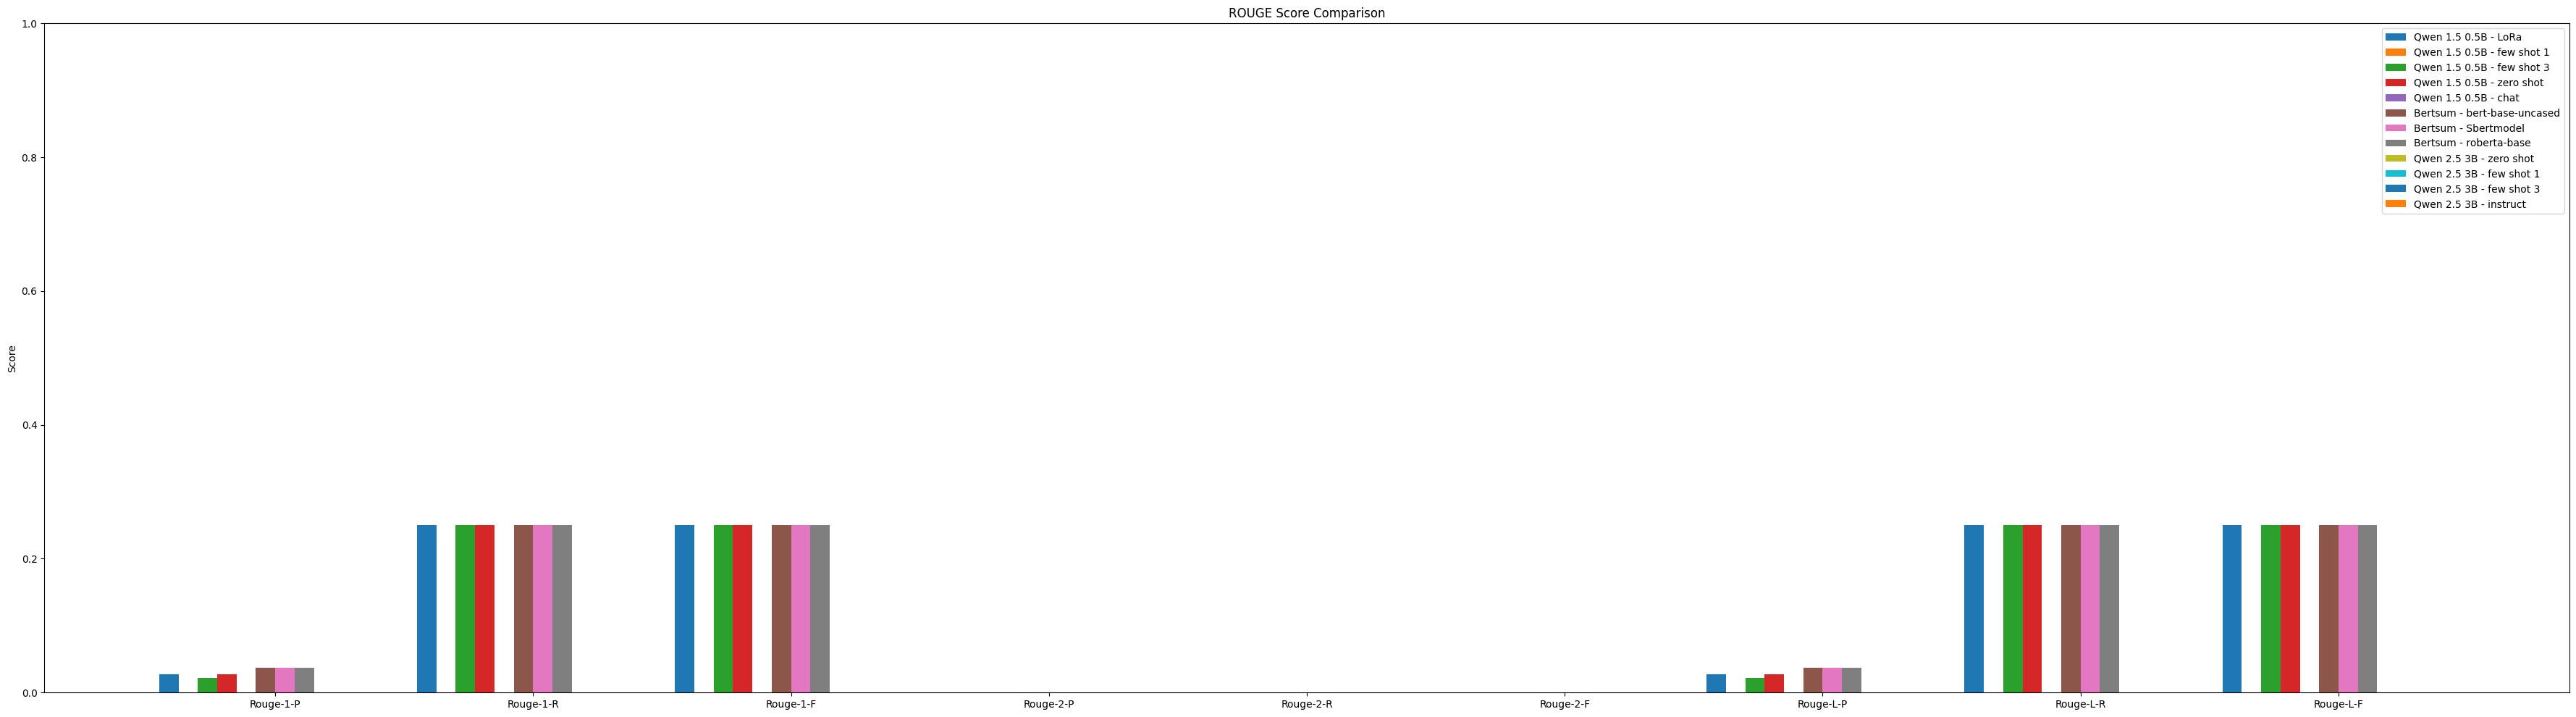

In [51]:
plot_data([data_ft, data_1,data_3, data_zero_shot,data_instruct_15, data_bertsum, data_bertsum_sbert,data_bertsum_roberta, data_better, data_better_1, data_better_3, data_instruct_25])


In [ ]:
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
print("Qwuen 2.5 3B zero shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B one shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt1_better, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B three shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt3_better, promptsuff = "[AGENT]", prints = True)


In [ ]:
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
data_qwen15 = np.array([data_zero_shot, data_1, data_3, data_ft])
data_bertsums = np.array([data_bertsum, data_bertsum_sbert, data_bertsum_roberta])
data_qwen25 = np.array([data_better, data_better_1, data_better_3])

print(data_qwen15)

In [ ]:
print(data_bertsums)

In [ ]:
print(data_qwen25)